In [1]:
import json
import os
import utils
import glob
import pandas as pd
import numpy as np

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

In [15]:
combine_samples = {
    # signal
    "GluGluHToWW_Pt-200ToInf_M-125": "ggH",
    "ttHToNonbb_M125": "ttH",
    "VBFHToWWToLNuQQ_M-125_withDipoleRecoil": "VBF",
    "HWplusJ_HToWW_M-125": "VH",
    "HZJ_HToWW_M-125": "VH",
    "HWminusJ_HToWW_M-125": "VH",
}

all_samples = ["ggH","ttH","VBF","VH"]

weights = {
    "mu": {
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_isolation_muon": 1,
        "weight_id_muon": 1,
    },
    "ele":{
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_electron": 1,
        "weight_reco_electron": 1,
        "weight_id_electron": 1,
    }
}

year = "2017"
samples_dir = f"../Feb23nosel_{year}"
samples = os.listdir(samples_dir)

all_samples = ["ggH"]
samples = ["GluGluHToWW_Pt-200ToInf_M-125"]

selection_by_ch = {
    "mu": {
        "trigger": "sel_trigger_mu==1",
        "metfilters": "sel_metfilters==1",
        "lepton-kin": "sel_leptonKin_mu==1",
        "fatjet-kin": "sel_fatjetKin==1",
        "ht": "sel_ht==1",
        "one-lepton": "sel_oneLepton_mu==1",
        "no-taus": "sel_notaus_mu==1",
        "in-jet-1.2": "lep_fj_dr < 1.2",
        "in-jet-0.8": "sel_leptonInJet==1",
        "iso": "(( (lep_pt < 55) & (lep_isolation < 0.15) ) | (lep_pt >= 55))",
        "mini-iso": "( (lep_pt < 55) | ( (lep_misolation < 0.1) & (lep_pt >= 55) ) )",
        "bjet_ophem": "( (fj_bjets_ophem < 0.3040) )", 
        "msd-20-260": "(fj_msoftdrop < 260 & fj_msoftdrop > 20)",
        "bjet": "(fj_bjets < 0.3040)", 
    },
    "ele": {
        "trigger": "sel_trigger_ele==1",
        "metfilters": "sel_metfilters==1",
        "lepton-kin": "sel_leptonKin_ele==1",
        "fatjet-kin": "sel_fatjetKin==1",
        "ht": "sel_ht==1",
        "one-lepton": "sel_oneLepton_ele==1",
        "no-taus": "sel_notaus_ele==1",
        "in-jet-1.2": "lep_fj_dr < 1.2",
        "in-jet-0.8": "sel_leptonInJet==1",
        "iso": "(( (lep_pt < 120) & (lep_isolation < 0.15) ) | (lep_pt >= 120))",
        "mini-iso": "( (lep_pt > 30 ) )", # equivalent to no-cut
        "bjet_ophem": "( (fj_bjets_ophem < 0.3040) )",
        "msd-20-260": "(fj_msoftdrop < 260 & fj_msoftdrop > 20)",
        "bjet": "(fj_bjets < 0.3040)", 
    }
}

cut_keys = ["All",r"Matched $h\rightarrow WW*$"]
cut_keys += list(selection_by_ch["mu"].keys())

sample_axis = hist2.axis.StrCategory([], name="samples", growth=True)
cutflow_axis = hist2.axis.Regular(
    len(cut_keys),
    0,
    len(cut_keys),
    name="var",
    label=r"Event Cutflow",
    overflow=True,
)
hist_cutflow = hist2.Hist(sample_axis,cutflow_axis)
    
nevents_dict = {s: 0 for s in all_samples}
neventsmatch_dict = {s: 0 for s in all_samples}
        
# channels = ["ele","mu"]
channels = ["mu"]

cut_events = {s: {}  for s in all_samples}

print(samples)
for sample in samples:
        
    ### get a combined label to combine samples of the same process
    for key in combine_samples:
        if key in sample:
            sample_to_use = combine_samples[key]
            break
        else:
            sample_to_use = sample
            
    out_files = f"{samples_dir}/{sample}/outfiles/"
    pkl_files = glob.glob(f"{out_files}/*.pkl")

    print(out_files)
    for ch in channels:
        
        # get lumi
        with open("../fileset/luminosity.json") as f:
            luminosity = json.load(f)[ch][year]

        # print(f"Finding {sample} samples and should combine them under {sample_to_use}")

        parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
        
        if not parquet_files:
            print(f"No parquet file for {sample}")
            continue                

        data = pd.read_parquet(parquet_files)
        empty = len(data) == 0
        if empty:
            continue
                    
        # get event_weight for events at this level of selection
        xsec_weight = utils.get_xsecweight(pkl_files, year, sample, False, luminosity)
        event_weight = xsec_weight
        for w in weights[ch]:
            if w not in data.keys():
                continue
            event_weight *= data[w]
            
        # how to compute cutflow:
        def get_nevents(data,sel_str,weights_to_apply,xsecw,is_data=False):
            d = data.query(sel_str)
            if not is_data:
                event_weight = xsecw
                for w in weights_to_apply:
                    try:
                        event_weight *= d[w]
                    except ValueError:
                        pass
            else:
                event_weight = np.ones_like(d["fj_pt"])
                        
            return np.sum(event_weight)
        
        nevents = np.sum(event_weight)
        nevents_signal_mask = get_nevents(data,"signal == 1",weights[ch],xsec_weight,False)
        nevents_signal_unmatch = get_nevents(data,"signal == 0",weights[ch],xsec_weight,False)
        fraction_match = nevents_signal_mask/nevents
        
        # print(f"No pre-selection - channel {ch}")
        # print(f"Number of events - scaled by xsec: {nevents}")
        # print(f"Number of events h->WW decay: {nevents_signal_mask}")
        # print(f"Number of events unmatched to h->WW decay: {nevents_signal_unmatch}")
        # print(f"Fraction of events in the sample {sample_to_use} matched to decay in channel {ch}: {fraction_match}")

        nevents_dict[sample_to_use] += nevents
        neventsmatch_dict[sample_to_use] += nevents_signal_mask
        
            
        hist_cutflow.fill(samples=sample_to_use, var=0, weight=nevents)
        # fill cutflow w events w signal mask cut
        hist_cutflow.fill(samples=sample_to_use, var=1, weight=nevents_signal_mask)
        
        # fill cutflow with other cuts
        i = 2
        presel_str = "signal == 1"
        for cut_key,sel_str in selection_by_ch[ch].items():
            presel_str += f" & {sel_str}"
            nevents_sel = get_nevents(data,presel_str,weights[ch],xsec_weight,False)
            hist_cutflow.fill(samples=sample_to_use, var=i, weight=nevents_sel)
            i+=1
            # print(presel_str,nevents_sel)
            if cut_key in cut_events[sample_to_use].keys():
                cut_events[sample_to_use][cut_key] += nevents_sel
            else:
                cut_events[sample_to_use][cut_key] = nevents_sel
        
print(nevents_dict)
for sample,total in nevents_dict.items():
    fraction_match = neventsmatch_dict[sample]/total
    print(f"Fraction of events in the sample matched to decay {fraction_match}")
    
print(nevents_dict)
print(neventsmatch_dict)
print(cut_events)

['GluGluHToWW_Pt-200ToInf_M-125']
../Feb23nosel_2017/GluGluHToWW_Pt-200ToInf_M-125/outfiles/
{'ggH': 4010.0866164580752}
Fraction of events in the sample matched to decay 1.0
{'ggH': 4010.0866164580752}
{'ggH': 4010.0866164580752}
{'ggH': {'trigger': 568.8605854510115, 'metfilters': 568.334116425617, 'lepton-kin': 519.855646712879, 'fatjet-kin': 427.14528203028107, 'ht': 426.79508659061474, 'one-lepton': 370.95650422622845, 'no-taus': 294.58215688817876, 'in-jet-1.2': 124.10008644818136, 'in-jet-0.8': 121.27150869907396, 'iso': 117.63908633348089, 'mini-iso': 109.18391604640017, 'bjet_ophem': 99.64310782472404, 'msd-20-260': 98.63203835559912, 'bjet': 90.25145056382658}}


In [3]:
hist_cutflow

Hist(
  StrCategory(['VBF', 'VH', 'ggH', 'ttH'], growth=True, name='samples'),
  Regular(16, 0, 16, name='var', label='Event Cutflow'),
  storage=Double()) # Sum: 238235.25934393436

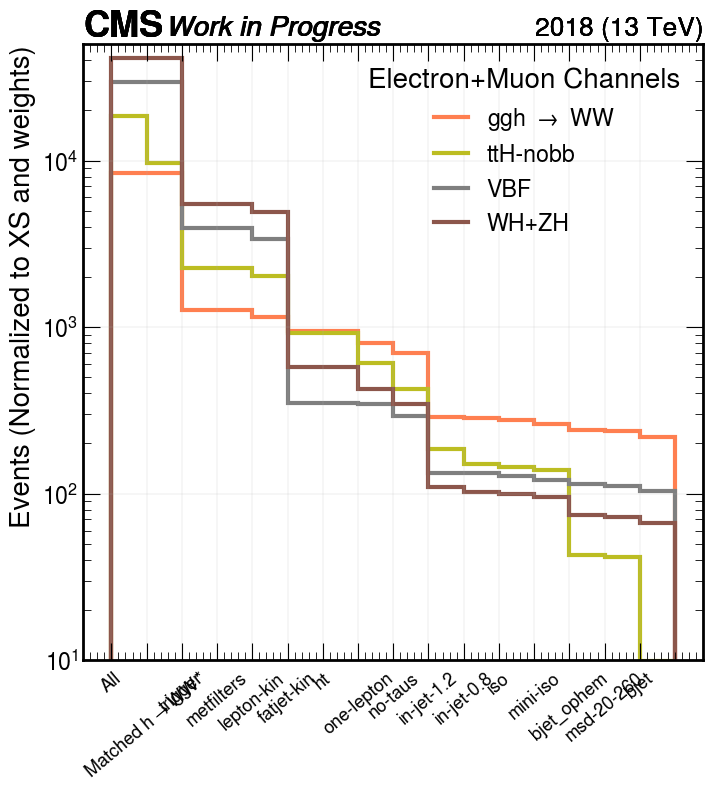

In [4]:
simplified_labels = {
    "ggH": r"ggh $\rightarrow$ WW",
    "ttH": r"ttH-nobb",
    "VBF": r"VBF",
    "VH": r"WH+ZH",
}
color_by_sample = {
    "ttH": "tab:olive",
    "ggH": "coral",
    "VH": "tab:brown",
    "VBF": "tab:gray",
}

fig, ax = plt.subplots(figsize=(8, 8))
for sample in all_samples:
    hep.histplot(
        hist_cutflow[{'samples': sample}],
        ax=ax,
        label=simplified_labels[sample],
        linewidth=3,
        color=color_by_sample[sample],
    )
    # hep.cms.lumitext(f"{year} (13 TeV)", ax=ax)
    hep.cms.lumitext(f"2018 (13 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)
    ax.legend(title=f"Electron+Muon Channels")
    ax.set_xticks(range(len(cut_keys)), cut_keys, rotation=40, fontsize=13)
    ax.set_ylabel("Events (Normalized to XS and weights)")
    ax.set_xlabel("")
    ax.set_ylim(10, 50000)
    ax.grid(linestyle='-', linewidth=0.2)
    ax.set_yscale("log")
